# Defacing pre-registration - Statistical analysis in R

## Load simulated or collected manual ratings

In [6]:
raters <- list('rater_01', 'rater_02', 'rater_03', 'rater_04')
for (rater in raters) {
  df_rater <- subset(df, rater_id == rater)
  # If an image was assigned several ratings by the same rater, we keep only the last one
  df_unique <- df_rater[!duplicated(df_rater[c("rater_id", "randomized_id")], fromLast = TRUE), ]
  print(paste(rater, ":", nrow(df_unique), "images rated"))
}

[1] "rater_01 : 450 images rated"
[1] "rater_02 : 450 images rated"
[1] "rater_03 : 450 images rated"
[1] "rater_04 : 450 images rated"


### Plot ratings distribution

To explore whether a bias is visible in the data, we plot for each rater the distribution of the ratings extracted from non-defaced versus defaced images.

In [4]:
# Convert defaced to factor for better visualization
df$defaced <- factor(df$defaced, levels = c(0, 1), labels = c("Non-defaced", "Defaced"))

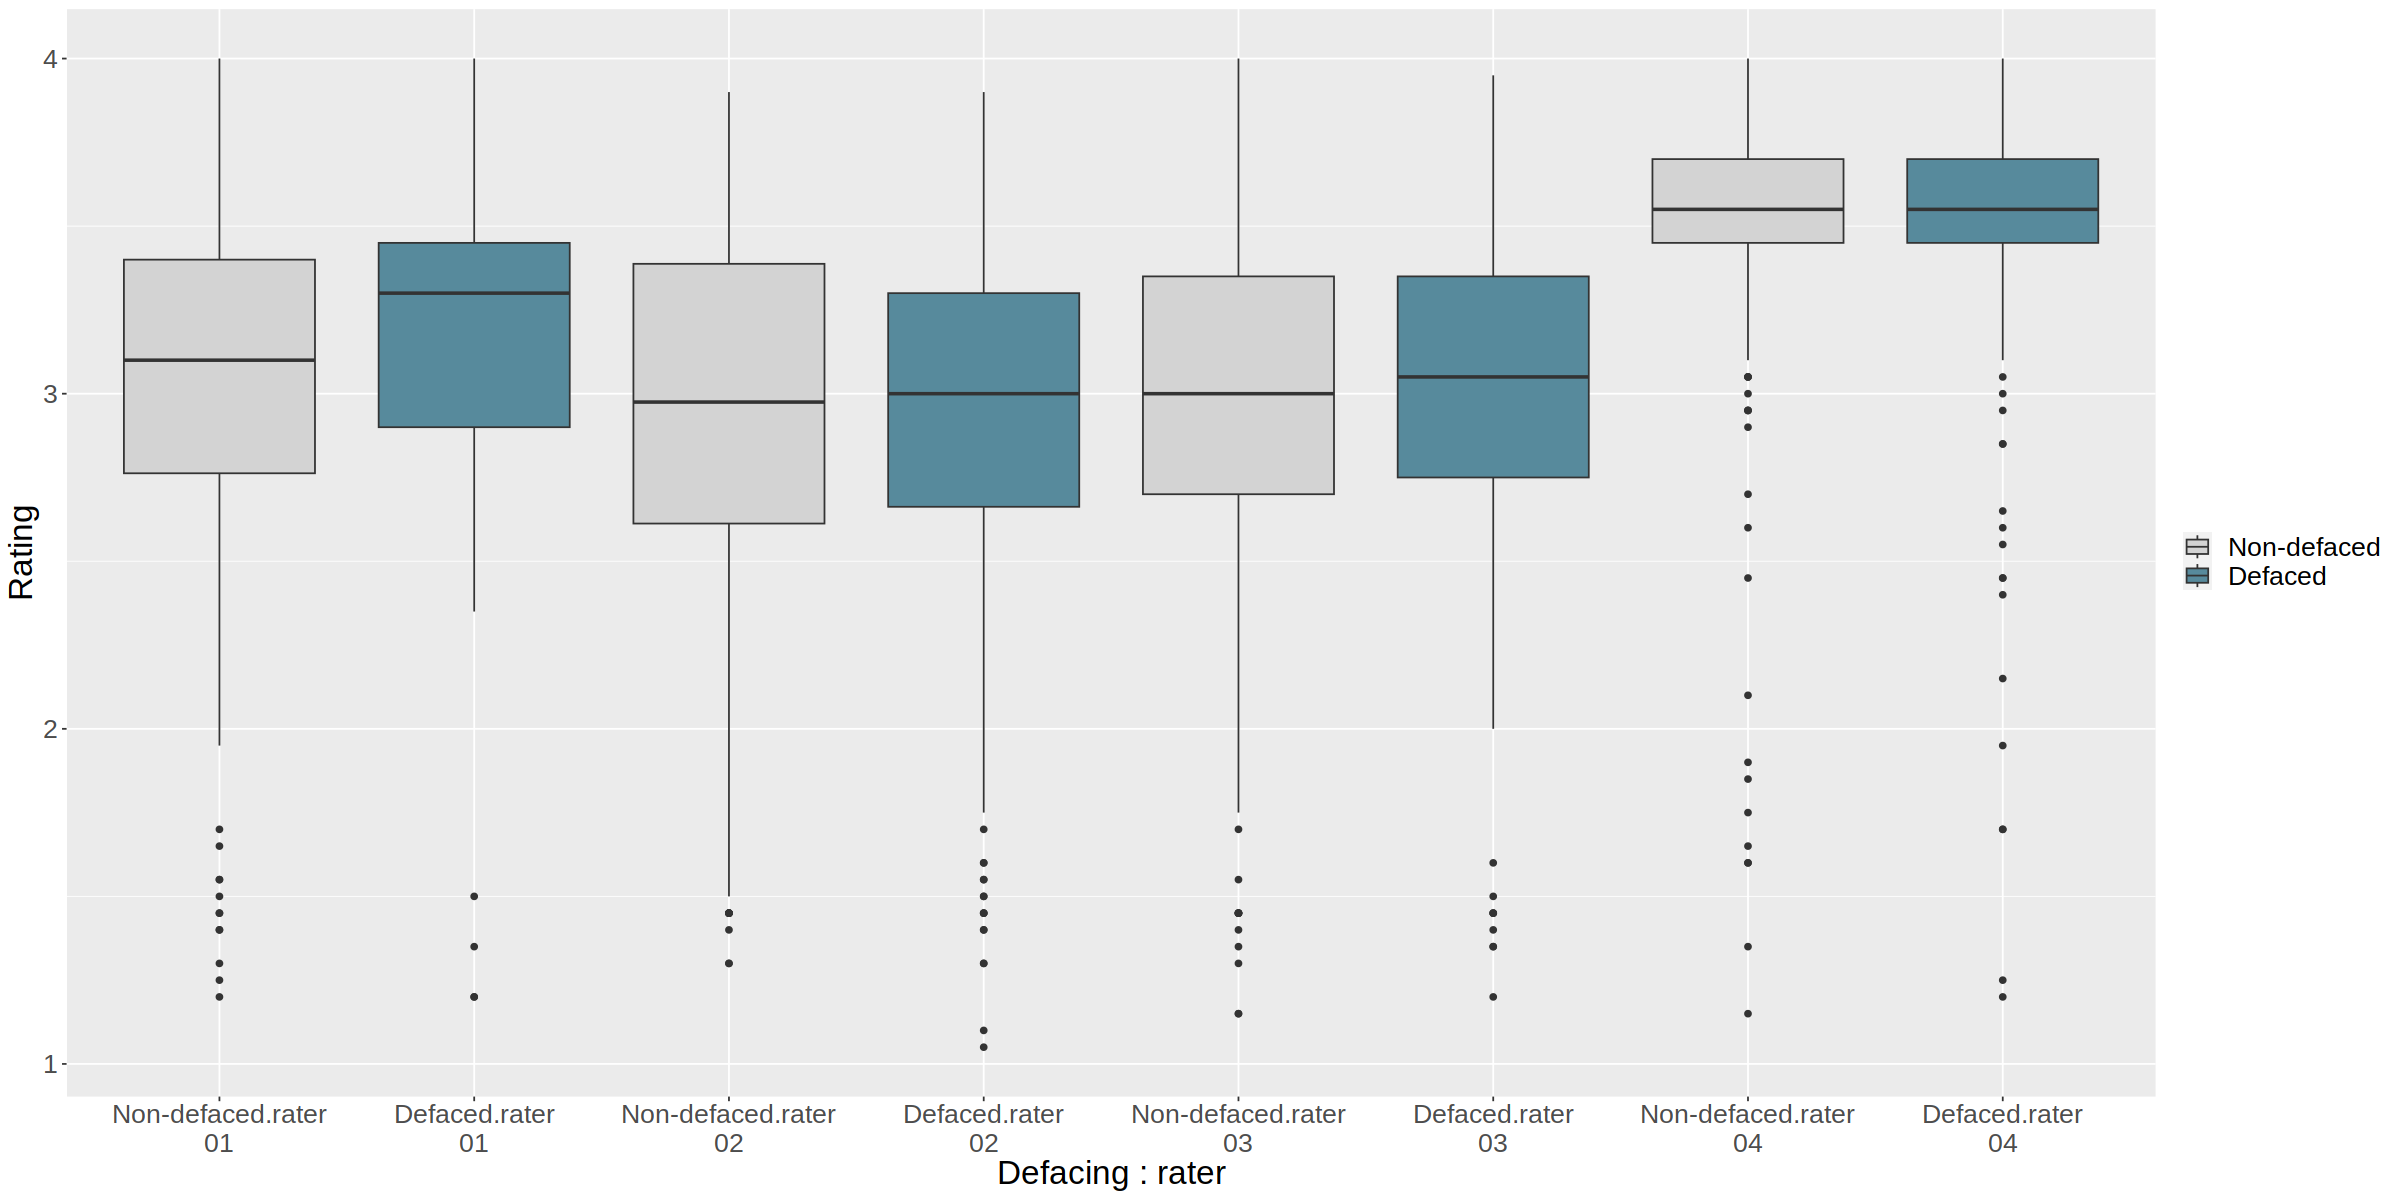

In [5]:
#change size of displayed plot
library(ggplot2)
#Increase plot size
options(repr.plot.width=20, repr.plot.height=10)

# Create boxplot
ggplot(df, aes(x = interaction(defaced, rater_id), y = rating, fill = defaced)) +
  geom_boxplot(position = position_dodge(0.8)) +
  scale_x_discrete(labels = function(x) gsub("_", "\n", x)) +
  labs(x = "Defacing : rater", y = "Rating", fill = "Defacement") +
  theme(text = element_text(size = 20)) +
  scale_fill_manual(values = c("Non-defaced" = "lightgrey", "Defaced" = "#578a9c")) +
  theme(legend.title = element_blank()) +
  theme(legend.position = "right")

It is interesting to see that different raters present a bias of different magnitude, our most expert rater is the one being most biased by the defacing process. It is also interesting to note that rater_04 was overall more optimistic about the images quality. Let us now perform statistical test to see whether the impact of defacing on the quality score is significant.

## Repeated-measures ANOVA

### Check assumptions

repeated-measure ANOVA makes the following three assumptions on the data :
1. **No significant outlier** : By construction the ratings cannot leave the range we define, so this assumption is granted
2. **Normality** : we will have many ratings so by the central theorem this assumption should be ok
3. **Sphericity** : the variance of the differences between groups should be equal.

In [4]:
##Test for normality
library(ggpubr)
shapiro.test(df$ratings)

ERROR: Error in library(ggpubr): there is no package called ‘ggpubr’


If the data is normally distributed, p-values should be greater than 0.05

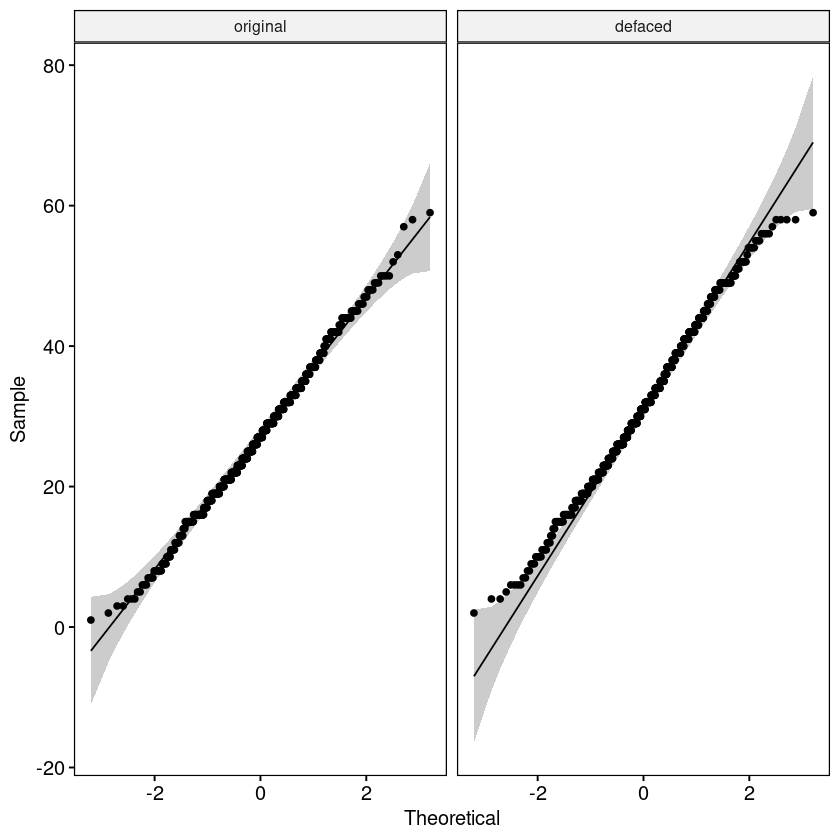

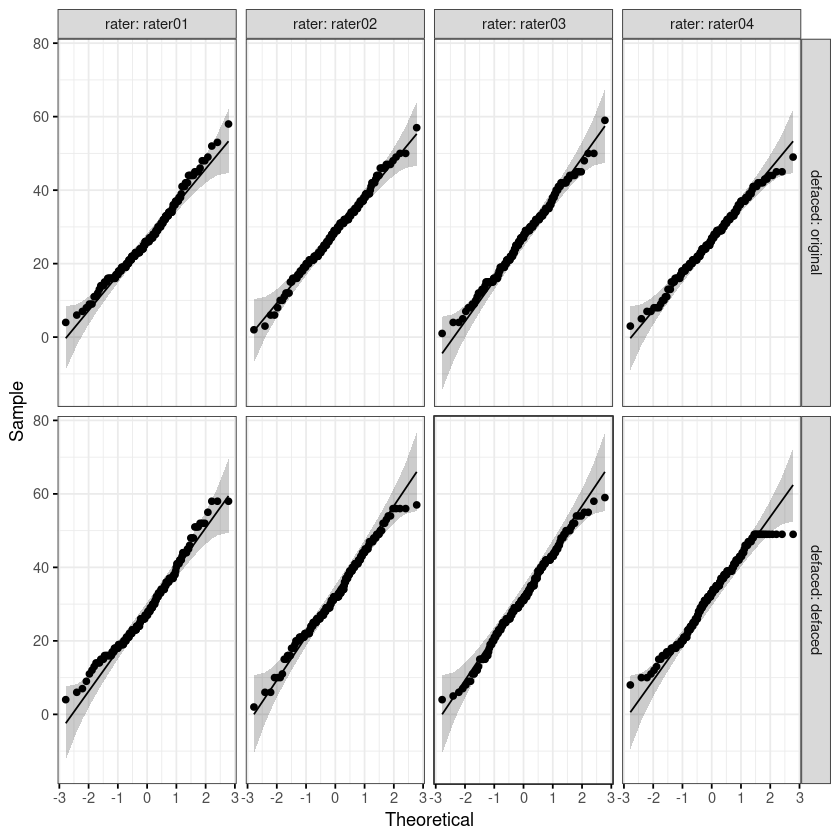

In [ ]:
## Other test for normality
ggqqplot(df, "ratings", facet.by = 'defaced')
ggqqplot(df, "ratings", ggtheme = theme_bw()) +
  facet_grid(defaced ~ rater, labeller = "label_both")

We can assume normality if the points fall along the reference line.

In [ ]:
## Test for sphericity
library(rstatix)
suppressWarnings(anova_test(data = df, dv = ratings, wid= sub, within = c(defaced, rater)))

ANOVA Table (type III tests)

$ANOVA
         Effect DFn DFd       F        p p<.05   ges
1       defaced   1 184 530.324 4.34e-56     * 0.038
2         rater   3 552   2.376 6.90e-02       0.008
3 defaced:rater   3 552  23.304 3.24e-14     * 0.005

$`Mauchly's Test for Sphericity`
         Effect     W     p p<.05
1         rater 0.983 0.687      
2 defaced:rater 0.936 0.035     *

$`Sphericity Corrections`
         Effect   GGe       DF[GG]    p[GG] p[GG]<.05   HFe       DF[HF]
1         rater 0.989 2.97, 545.82 7.00e-02           1.007 3.02, 555.74
2 defaced:rater 0.959 2.88, 529.59 9.82e-14         * 0.976  2.93, 538.9
    p[HF] p[HF]<.05
1 6.9e-02          
2 6.2e-14         *

For the assumption of sphericity to be verified, the test should not reject the null hypothesis, which is that the variance between group is equal. If any assumption is violated, we will switch to the alternative analysis using linear mixed-effects models.

### Run ANOVA

In [ ]:
suppressWarnings(res.aov <- anova_test(data = df, dv = ratings, wid = sub, within = c(defaced, rater)))
get_anova_table(res.aov)

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,defaced,1.00,184.00,530.324,4.34e-56,*,0.038
2,rater,3.00,552.00,2.376,6.90e-02,,0.008
3,defaced:rater,2.88,529.59,23.304,9.82e-14,*,0.005


### Verify that the null hypothesis is not rejected if no bias has been introduced

In [ ]:
#Define for each rater the percentage of biased ratings
perc_biased <- c(10,10,10,10)
bias <- 1

df_nobias <- simulate_normal_data(n_rated, n_sub, n_rater, perc_biased, mean=mean, sd=sd, bias=bias)
df_nobias$ratings <- as.numeric(df_nobias$ratings)

## Lmer should not find significant result
suppressWarnings(res.aov <- anova_test(data = df_nobias, dv = ratings, wid = sub, within = c(defaced, rater)))
get_anova_table(res.aov)

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,defaced,1,184,78.645,6.41e-16,*,2.41e-05
2,rater,3,552,1.660,1.75e-01,,7.00e-03
3,defaced:rater,3,552,0.015,9.97e-01,,1.44e-08


## Friedman test

Non-parametric alternative to repeated-measure ANOVA.

In [ ]:
friedman.test(y=df$ratings, groups=factor(df$defaced), blocks=factor(df$sub))

ERROR: Error in friedman.test.default(y = df$ratings, groups = factor(df$defaced), : not an unreplicated complete block design


Cannot use this function : An unreplicated complete block design has exactly 1 observation for each combination of the two grouping factors. But we have 4 observations of the combination defaced + sub 1 : rater01,02,03,04.